In [1]:
# Tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado y evaluación
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('once')

##### <font color=green>En el pair programming de hoy debéis usar el csv que guardastéis cuando hicistéis el pairprgramming de codificicación (este csv debería tener las variables estadandarizas).


In [2]:
df= pd.read_pickle('datos/cars_price_norm_est_cod.pkl')
df.head(2)

,Levy,Prod_year,Mileage,Cylinders,Airbags,Price_log,Leather_interior_le,Category_Cabriolet,Category_Coupe,Category_Goods wagon,...,Fuel_type_LPG,Fuel_type_Petrol,Fuel_type_Plug-in Hybrid,Gear_box_type_Automatic,Gear_box_type_Manual,Gear_box_type_Tiptronic,Gear_box_type_Variator,Drive_wheels_4x4,Drive_wheels_Front,Drive_wheels_Rear
0,1.766963,-0.411248,0.237134,1.375313,1.329406,9.497622,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0
1,0.943936,-0.173337,0.273438,1.375313,0.319668,9.718422,0,0,0,0,...,0,1,0,0,0,1,0,1,0,0


##### <font color=green>En pairprogramming anteriores ajustastéis vuestro datos a una regresión lineal. El objetivo de hoy es:
- Ajustar el modelo a un Decision Tree
- Extraer las métricas
- Debatid entre vosotras que modelo es mejor y por qué (basándose en las métricas)

In [3]:
# al igual que en la regresión lineal tenemos que separar nuestro dataframe en X e y
X = df.drop("Price_log", axis = 1)
y = df["Price_log"]

In [4]:
# y dividir nuestros datos en train y test para poder evaluar la bondad de nuestro modelo

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

Primero ajustamos el modelo

In [5]:
# creamos el objeto del modelo, al igual que hacíamos en la regresión lineal
arbol = DecisionTreeRegressor(random_state =0)

# ajustamos el modelo, igual que en la regresión lienal. 
arbol.fit(x_train, y_train)


DecisionTreeRegressor(random_state=0)

Representación del árbol.

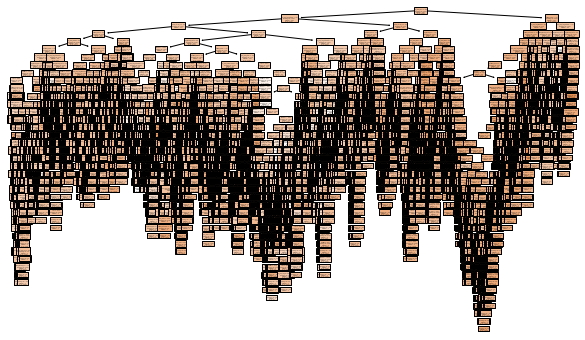

In [6]:
fig = plt.figure(figsize = (10,6))
tree.plot_tree(arbol, feature_names = x_train.columns, filled = True)
plt.show()

In [7]:
# max features

max_features = np.sqrt(len(x_train.columns))
max_features

5.5677643628300215

Como vemos, debemos poner en nuestro modelo una profundidad máxima de 6.

In [8]:
# max depth

print(arbol.tree_.max_depth)

41


In [9]:
# hacemos las predicciones sobre los dos set de datos el X_test y el X_train
y_pred_test_dt = arbol.predict(x_test)
y_pred_train_dt = arbol.predict(x_train)

In [10]:
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    
    
    resultados = {'MAE': [mean_absolute_error(y_test, y_test_pred), mean_absolute_error(y_train, y_train_pred)],
                'MSE': [mean_squared_error(y_test, y_test_pred), mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(mean_squared_error(y_test, y_test_pred)), np.sqrt(mean_squared_error(y_train, y_train_pred))],
                'R2':  [r2_score(y_test, y_test_pred), r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df

Sacamos las métricas para ver si hay overfitting o underfitting, para modificar la profundidad en función de estos resultados

In [11]:
dt_results1 = metricas(y_test, y_train, y_pred_test_dt, y_pred_train_dt, "Decission Tree I")
dt_results1

,MAE,MSE,RMSE,R2,set,modelo
0,0.867478,1.558702,1.24848,-0.590452,test,Decission Tree I
1,0.004271,0.004474,0.06689,0.995488,train,Decission Tree I


---------------
Recordemos cuando había *overfitting* o *underfitting* 

- Si los valores del *train* son MUCHO MEJOR (que es tener métricas más bajas, excepto en el R² que sería tener valores más altos) que los del *test* --> ***overfitting***. En este caso, nuestro modelo se estaría aprendiendo de memoria los datos de entrenamiento y no sería capaz de hacer buenas predicciones fuera de ese set de datos.

- Si los valores del *train* son MUCHO PEOR (valores de las métricas más altas, excepto en el R² que sería tener valores más bajos) que los del *test* --> ***underfitting***. En este caso, nuestro modelo no es lo suficientemente bueno para generalizar a los datos de test ni para modelar decentemente los del *train*.

-------------------

`Luego de recordar los conceptos, vemos que nuestros valores del *train* son MUCHO MEJOR, es decir en el R² tenemos valores más altos por estar más cerca de 1 y el MAE, MSE, RMSE tenemos valores más bajos por estar más cerca de 0, lo que significa que tenemos overfitting y por lo tanto tendremos que reducir la profundidad de nuestro modelo.`

In [12]:
# lo primero que tenemos que hacer es definir un diccionario con los hiperparámetros que queremos modificar y los valores que queremos 

param = {"max_depth": [2,4, 6], # teniendo en cuenta que teníamos overfitting tendremos que reducir la profundidad del modelo, la nuestra anterior era de 41. Bajaremos mucho este valor ya que teníamos un overfitting muy claro
        "max_features": [1,2,3,4],# calculamos en celdas anteriores, probaremos a hacer el modelo como una variable, 2, 3 y 4. Ponemos como límite el 4 ya que es el resultado de la raiz cuadrada. 
        # estos dos hiperparámetros son más difíciles de definir, pero usualmente se suelen elegir los siguientes valores
        "min_samples_split": [10, 50, 100],
        "min_samples_leaf": [10,50,100]} 


In [13]:
# una vez creado el diccionario iniciaremos el modelo con GridSearch

gs = GridSearchCV(
            estimator=DecisionTreeRegressor(), # tipo de modelo que queremos hacer
            param_grid= param, # que hiperparámetros queremos que testee
            cv=10, # crossvalidation que aprendimos en la lección de regresión lineal intro. 
            verbose=-1, # para que no nos printee ningún mensaje en pantalla
            return_train_score = True, # para que nos devuelva el valor de las métricas de set de datos de entrenamiento
            scoring="neg_mean_squared_error") # la métrica que queremos que nos devuelva

In [14]:
# ajustamos el modelo que acabamos de definir en el GridSearch

gs.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [2, 4, 6], 'max_features': [1, 2, 3, 4],
                         'min_samples_leaf': [10, 50, 100],
                         'min_samples_split': [10, 50, 100]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=-1)

In [15]:
# este método nos esta diciendo que el mejor modelo es aquel que tiene una profundidad de 6, que usa 4 variables predictoras para construir el modelo y que tiene  un min_samples_leaf y un min_samples_split de 10. 
mejor_modelo = gs.best_estimator_
mejor_modelo

DecisionTreeRegressor(max_depth=6, max_features=4, min_samples_leaf=10,
                      min_samples_split=10)

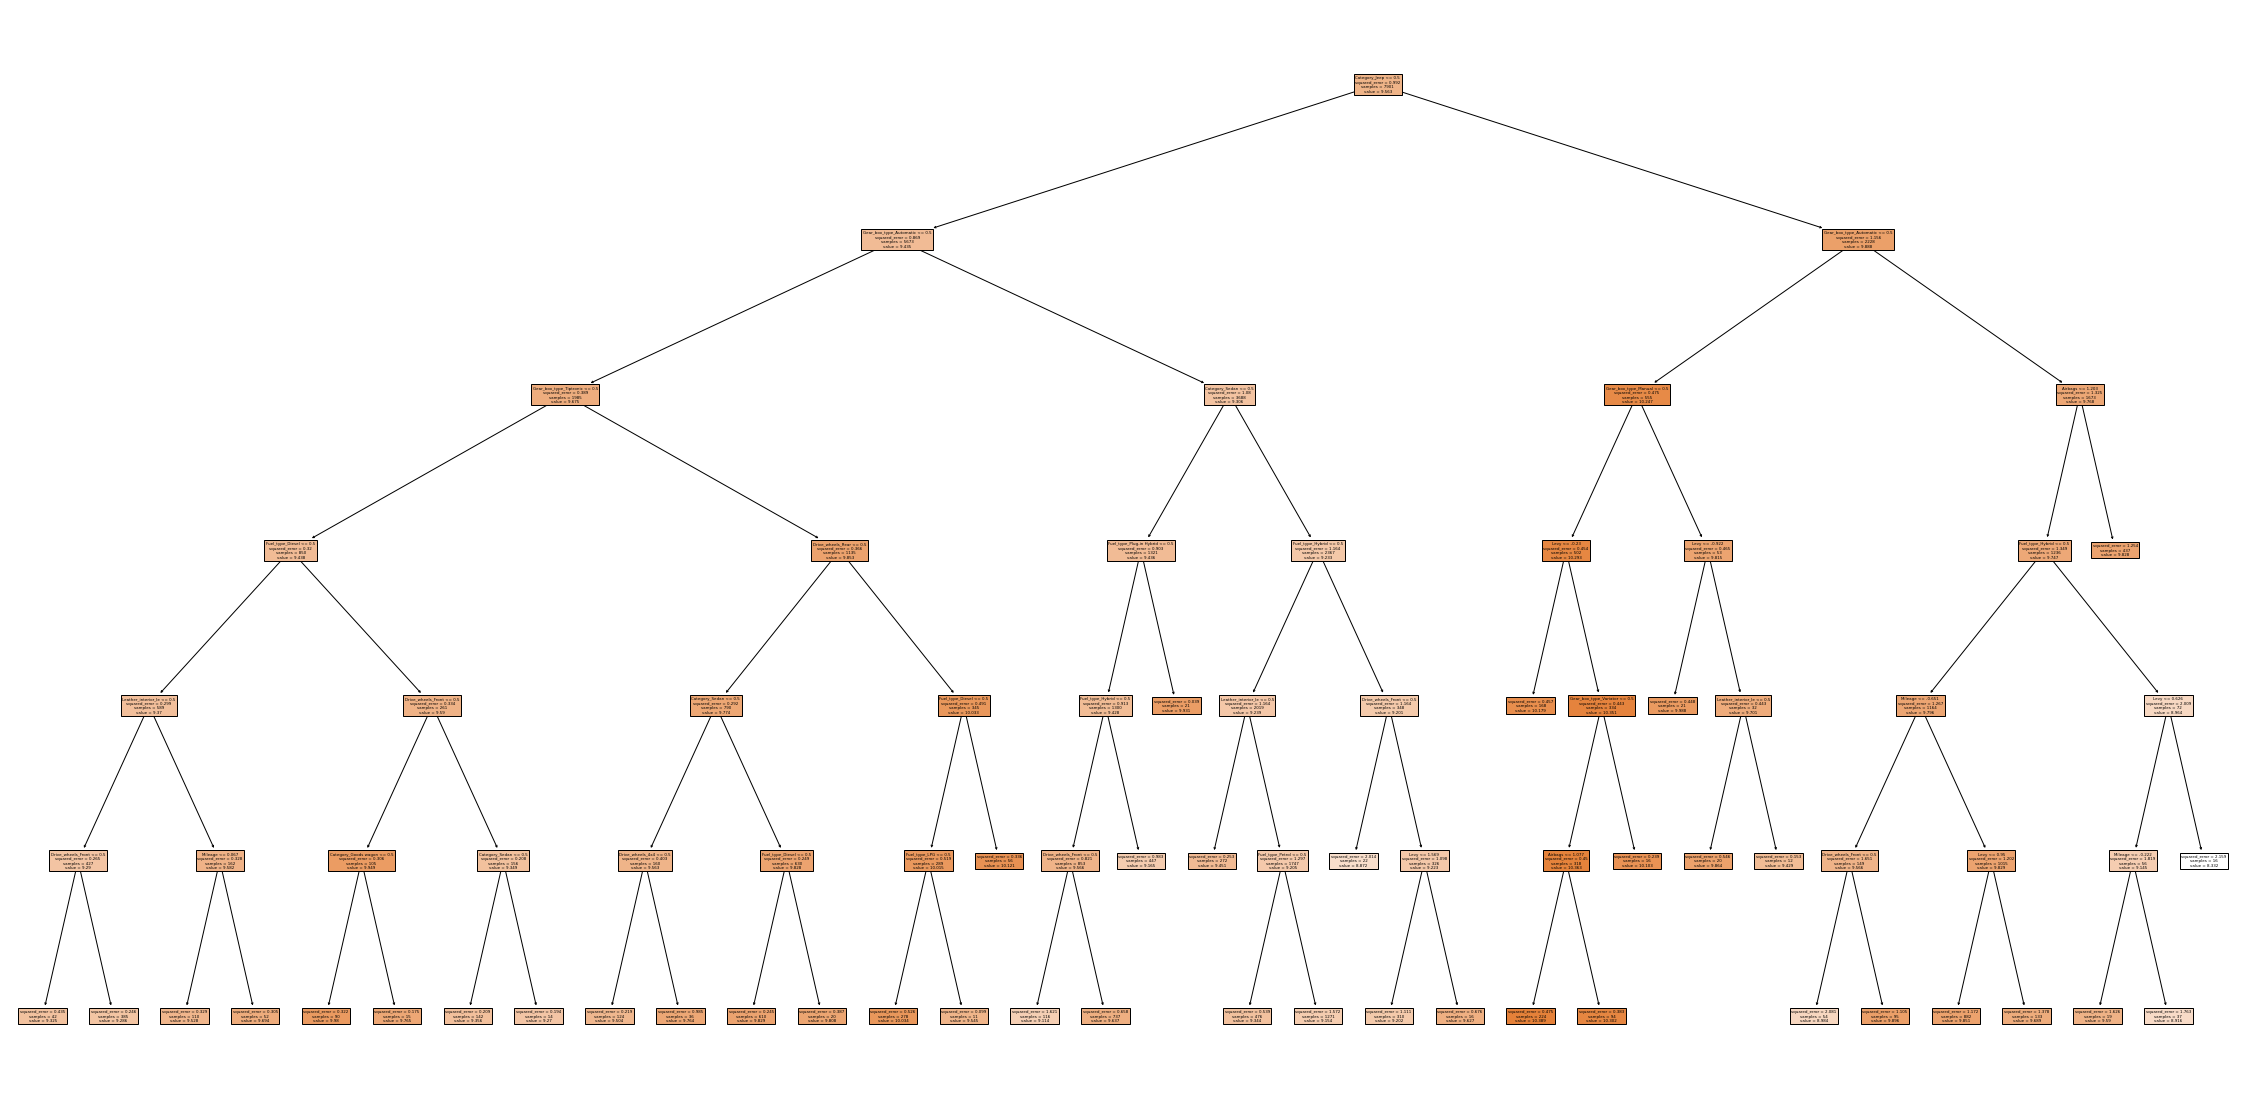

In [16]:
# veamos ahora que pinta tiene nuestro árbol


fig = plt.figure(figsize=(40, 20))
tree.plot_tree(mejor_modelo, feature_names=x_train.columns, filled=True);

<font color=violet>Por fin vemos algo bonito. Lágrimas de felicidad, abrazos!!! Ahora vamos a calcular las métricas para ver si es bueno prediciendo o no.

In [17]:
y_pred_test_dt2 = mejor_modelo.predict(x_test)
y_pred_train_dt2 = mejor_modelo.predict(x_train)

In [18]:
dt_results2 = metricas(y_test, y_train, y_pred_test_dt2, y_pred_train_dt2, "Decision tree II")
dt_results2


,MAE,MSE,RMSE,R2,set,modelo
0,0.664417,0.880556,0.938380,0.101508,test,Decision tree II
1,0.670069,0.861764,0.928313,0.130892,train,Decision tree II


In [19]:
# vamos  a juntar los dataframes de los resultados de los modelos para poder compararlos mejor

df_decision_results = pd.concat([dt_results1, dt_results2], axis = 0)
df_decision_results

,MAE,MSE,RMSE,R2,set,modelo
0,0.867478,1.558702,1.248480,-0.590452,test,Decission Tree I
1,0.004271,0.004474,0.066890,0.995488,train,Decission Tree I
0,0.664417,0.880556,0.938380,0.101508,test,Decision tree II
1,0.670069,0.861764,0.928313,0.130892,train,Decision tree II


In [22]:
# En la clase de métricas guardamos en un pickle los resultados de las métricas del modelo de regresión lineal
# hoy vamos a cargar ese pickle y lo vamos a unir al dataframe que acabamos de crear con los resultados del decision tree para comparar las métricas

df_linear_results = pd.read_pickle('datos/cars_price_LR.pkl')
df_linear_results


,MAE,MSE,RMSE,R2,set,modelo
0,2.512446e+07,1.247327e+18,1.116838e+09,-1.272734e+18,test,Linear Regresion
1,6.598452e-01,8.415469e-01,9.173586e-01,1.512823e-01,train,LinearRegression


In [23]:
# concatenamos todos los resultados

df_DT_LR_results = pd.concat([df_linear_results, df_decision_results], axis = 0)
df_DT_LR_results

,MAE,MSE,RMSE,R2,set,modelo
0,2.512446e+07,1.247327e+18,1.116838e+09,-1.272734e+18,test,Linear Regresion
1,6.598452e-01,8.415469e-01,9.173586e-01,1.512823e-01,train,LinearRegression
0,8.674777e-01,1.558702e+00,1.248480e+00,-5.904517e-01,test,Decission Tree I
1,4.270798e-03,4.474313e-03,6.689030e-02,9.954876e-01,train,Decission Tree I
0,6.644175e-01,8.805562e-01,9.383796e-01,1.015077e-01,test,Decision tree II
1,6.700689e-01,8.617644e-01,9.283127e-01,1.308925e-01,train,Decision tree II


In [ ]:
#OJO FALTA ANÁLISIS

<font color=violet>Guardamos este df para usarlo en próximas lecciones.

In [24]:
df_DT_LR_results.to_pickle('datos/cars_price_LR_DT.pkl')

In [25]:
df_DT_LR_results.to_csv('datos/cars_price_LR_DT.csv')

In [26]:
# vamos a crearnos un dataframe, para ver la importancia de cada una de las variables incluidas en el modelo

importancia_predictores = pd.DataFrame(
                            {'predictor': x_train.columns,
                             'importancia': mejor_modelo.feature_importances_}
                            )


# ordenamos de mayor a menor los resultados
importancia_predictores.sort_values(by=["importancia"], ascending=False, inplace = True)

# printeamos los resultados
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
10,Category_Jeep,0.319774
24,Gear_box_type_Automatic,0.264921
19,Fuel_type_Hybrid,0.092252
26,Gear_box_type_Tiptronic,0.081613
29,Drive_wheels_Front,0.079251
15,Category_Sedan,0.042878
5,Leather_interior_le,0.025007
0,Levy,0.017879
30,Drive_wheels_Rear,0.015629
2,Mileage,0.015327


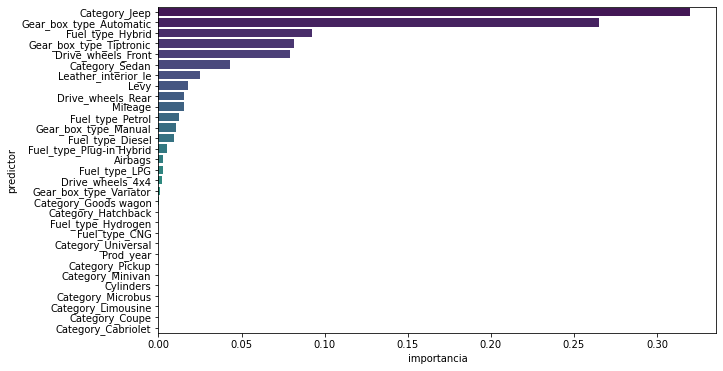

In [27]:
# por último ploteamos los resultados para verlo de una forma más amigable. 

plt.figure(figsize=(10,6))
sns.barplot(x = "importancia", y = "predictor", data = importancia_predictores, palette="viridis");
plt.show()